In [4]:
#!pip install pydub
#!pip install google-cloud-speech
#!pip install google-cloud-storage

In [5]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [45]:
import io
import os

from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

from google.cloud import speech_v1
from google.cloud.speech_v1 import enums
from google.cloud.speech_v1 import types

import librosa
import librosa.display
import IPython.display

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pandas as pd

import soundfile as sf
import json

In [7]:
GOOGLE_APPLICATION_CREDENTIALS="graphite-shell-268204-39d77f46c835.json"

### 1. 녹음 파일 자르기

In [8]:
# 녹음파일 경로에서 파일이름만 빼내기(?)

audio_path = 'hyunbin.wav'
(file_dir, file_id) = os.path.split(audio_path)
print("file_dir:", file_dir)
print("file_id:", file_id)

file_dir: 
file_id: hyunbin.wav


C:\Users\vdi02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vdi02\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


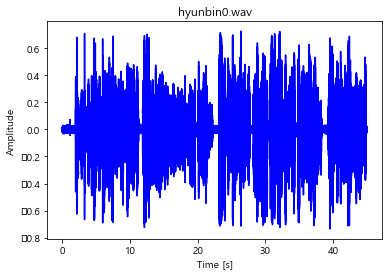

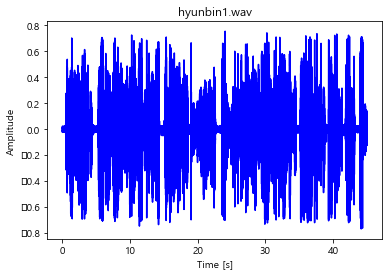

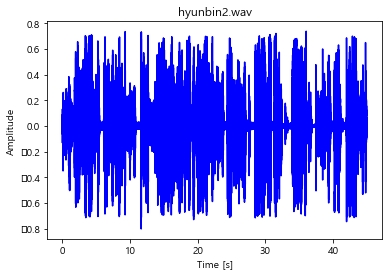

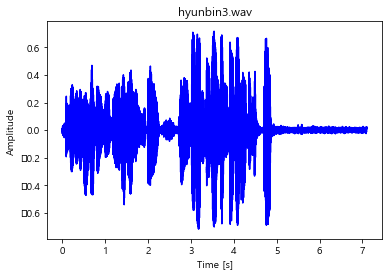

In [9]:
y, sr = librosa.load(audio_path, sr=16000)

X = 45 # 끊을 초
t = len(y)//sr//X+1

columns = ['cut_audio']
cut_df = pd.DataFrame(columns=columns)

for i in range(t):
    # 오디오 자르기
    cut_y = y[round(i*X*16000) : round((i+1)*X*16000)]
    
    audio_name = file_id.split('.wav')[0]
    cut_audio = '{}{}.wav'.format(audio_name, i)
    
    # 저장
    sf.write(cut_audio, cut_y, 16000, format='wav', subtype='PCM_16')
    
    # cut_df에 넣기
    #(file_dir, file_id) = os.path.split(audio_path)
    cut_df.loc[i,['cut_audio']] = cut_audio
    
    i+=1
    
    # 시각화
    time = np.linspace(0, len(cut_y)/sr, len(cut_y))
    fig, ax = plt.subplots()
    ax.plot(time, cut_y, color = 'b', label='speech waveform')
    ax.set_ylabel("Amplitude") # y 축
    ax.set_xlabel("Time [s]") # x 축
    plt.title(cut_audio)
    plt.show()

In [10]:
cut_df

,cut_audio
0,hyunbin0.wav
1,hyunbin1.wav
2,hyunbin2.wav
3,hyunbin3.wav


In [11]:
# len(cut_df)
cut_df['cut_audio'][0]

'hyunbin0.wav'

### 2. 화자구분 cut / 저장

In [12]:
# 화자구분

import requests

def vfilter(cut_audio):
    files = {
        'apiId': (None, 'dhguswl12303061dc811a'),
        'apiKey': (None, '0ad29b46083a42ed8700d23f2d90e78a'),
        'reqVoice': (cut_audio, open(cut_audio, 'rb')),
    }

    response = requests.post('https://api.maum.ai/api/dap/diarize/', files=files)
    
    return response

0  >>  {"message":{"message":"Success","status":0},"data":[{"speaker":0,"startTime":0.0,"endTime":1.6},{"speaker":1,"startTime":1.6,"endTime":11.600000000000001},{"speaker":0,"startTime":11.600000000000001,"endTime":22.400000000000002},{"speaker":1,"startTime":22.400000000000002,"endTime":27.6},{"speaker":0,"startTime":27.6,"endTime":38.800000000000004},{"speaker":1,"startTime":38.800000000000004,"endTime":44.400000000000006}]}



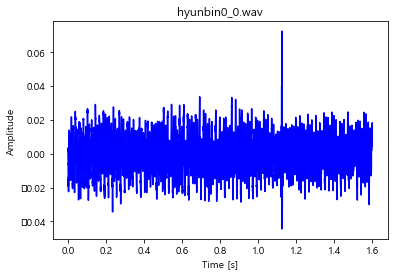

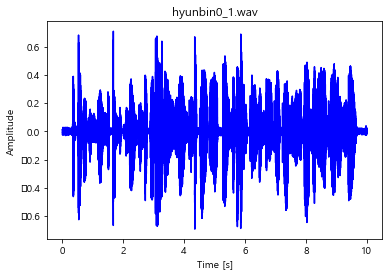

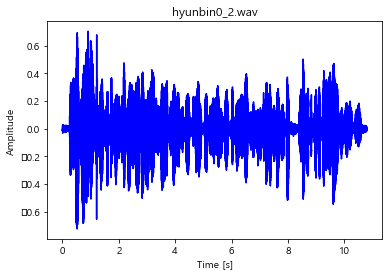

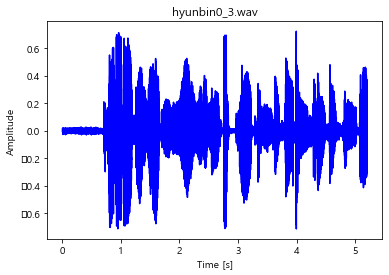

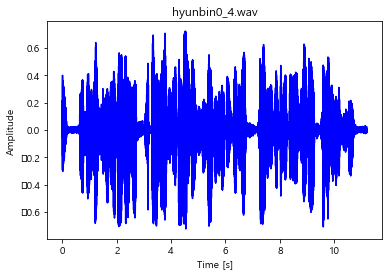

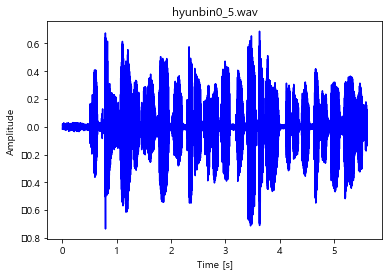

1  >>  {"message":{"message":"Success","status":0},"data":[{"speaker":0,"startTime":0.0,"endTime":4.4},{"speaker":1,"startTime":4.4,"endTime":14.4},{"speaker":0,"startTime":14.4,"endTime":23.200000000000003},{"speaker":1,"startTime":23.200000000000003,"endTime":35.2},{"speaker":0,"startTime":35.2,"endTime":43.6},{"speaker":1,"startTime":43.6,"endTime":44.400000000000006}]}



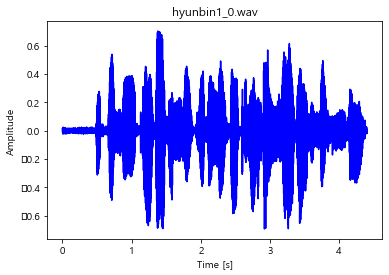

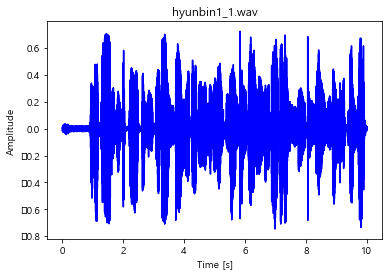

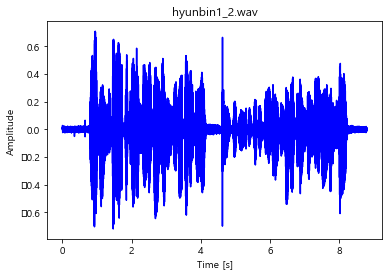

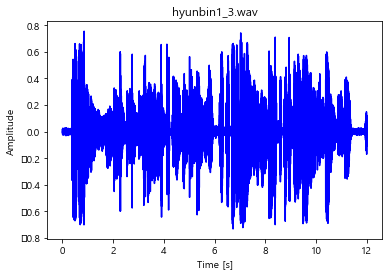

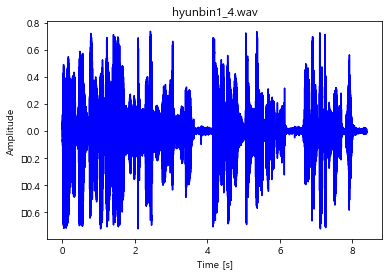

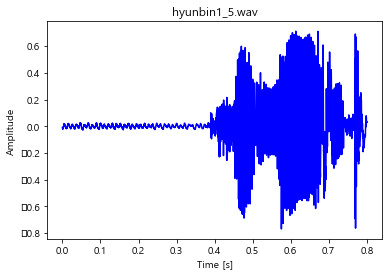

2  >>  {"message":{"message":"Success","status":0},"data":[{"speaker":0,"startTime":0.0,"endTime":5.6000000000000005},{"speaker":1,"startTime":5.6000000000000005,"endTime":10.8},{"speaker":0,"startTime":10.8,"endTime":24.400000000000002},{"speaker":1,"startTime":24.400000000000002,"endTime":32.800000000000004},{"speaker":0,"startTime":32.800000000000004,"endTime":44.400000000000006}]}



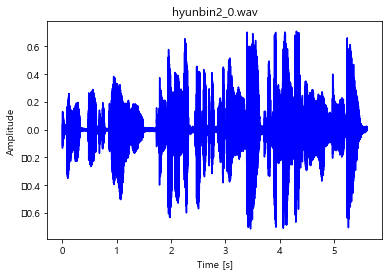

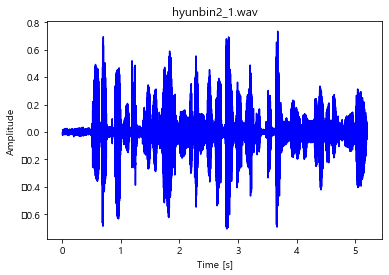

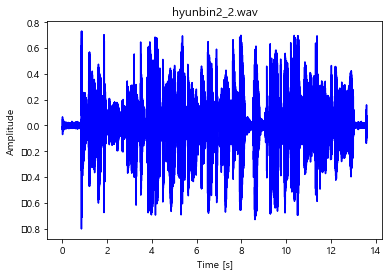

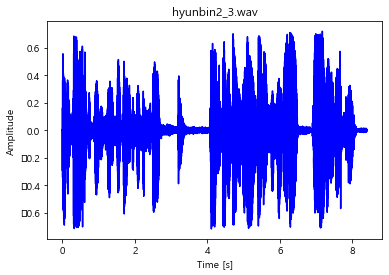

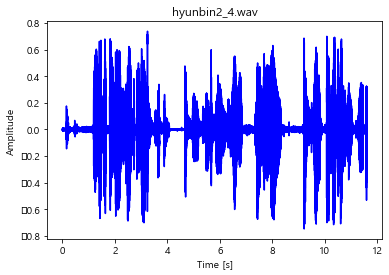

3  >>  {"message":{"message":"Success","status":0},"data":[{"speaker":1,"startTime":0.0,"endTime":4.800000000000001},{"speaker":0,"startTime":4.800000000000001,"endTime":6.4}]}



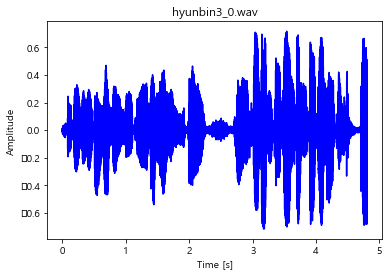

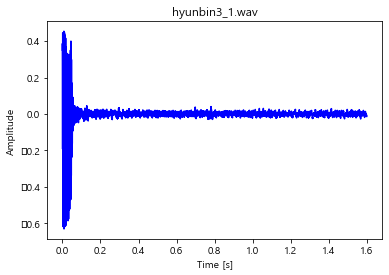

In [13]:
columns = ['cut2_audio']
cut2_df = pd.DataFrame(columns=columns)

z = 0
for i in range(len(cut_df)):
    cut_audio = cut_df['cut_audio'][i]
    
    # API 요청
    response = vfilter(cut_audio)
    print(i,' >> ',response.text)
    print()
    
    # json
    dict = json.loads(response.text)
    #for h in dict['data']:
    #    print('speaker >> ',h['speaker'],'|', 'startTime >> ',h['startTime'],'|', 'endTime >> ',h['endTime'])
    #print()
    
    #(file_dir, file_id) = os.path.split(cut_audio)
    y, sr = librosa.load(cut_audio, sr=16000)
    
    j = 0
    
    for d in dict['data']:
        
        # 오디오 자르기
        cut2_y = y[round(d['startTime']*16000) : round(d['endTime']*16000)]
        
        audio_name = cut_audio.split('.wav')[0]
        audio_path = '{}_{}.wav'.format(audio_name, j)
        # 저장
        sf.write(audio_path, cut2_y, 16000, format='wav', subtype='PCM_16')
        
        # cut2_df에 넣기
        
        (file_dir, file_id) = os.path.split(audio_path)
        cut2_df.loc[z,['cut2_audio']] = file_id
        
        # 시각화
        time = np.linspace(0, len(cut2_y)/sr, len(cut2_y))
        fig, ax = plt.subplots()
        ax.plot(time, cut2_y, color = 'b', label='speech waveform')
        ax.set_ylabel("Amplitude") # y 축
        ax.set_xlabel("Time [s]") # x 축
        plt.title(file_id)
        #plt.savefig('cut_half '+file_id+'.png')
        plt.show()
        
        j+=1
        z+=1
        

In [14]:
cut2_df

,cut2_audio
0,hyunbin0_0.wav
1,hyunbin0_1.wav
2,hyunbin0_2.wav
3,hyunbin0_3.wav
4,hyunbin0_4.wav
5,hyunbin0_5.wav
6,hyunbin1_0.wav
7,hyunbin1_1.wav
8,hyunbin1_2.wav
9,hyunbin1_3.wav


### 3. Speech to text

In [15]:
def transcribe_cut2(cut2_audio):
    client = speech.SpeechClient()
    
    with io.open(cut2_audio, 'rb') as f:
        content = f.read()
    audio = {"content": content}
    #audio = types.RecognitionAudio(content=content)
    
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        #sample_rate_hertz=16000,
        language_code='ko-KR',
        audio_channel_count=1)
    
    response = client.recognize(config, audio)
    
    return response

In [16]:
for i in range(len(cut2_df)):
    cut2_audio = cut2_df['cut2_audio'][i]
    
    # API 요청
    response = transcribe_cut2(cut2_audio)
    
    for result in response.results:
        alternative = result.alternatives[0]
        print(u"Transcript: {}".format(alternative.transcript))

Transcript: 앞에서 잠시 언급한 것처럼 컴퓨터 프로그래밍이란 컴퓨터에게 어떤 작업을 시키는 건데 그렇게 하기 위해서 자료를 주어야 합니다
Transcript: 우리가 자료를 주면 컴퓨터는 그 자료를 메모리 어딘가에 저장해 두고 필요할 때 사용하는데 그 자료를 2는 장소가 너무 많아서 이름을 붙여서 관리를 하게 되지요
Transcript: 자료를 관리하기 위해 이름을 붙여 도는 것을 변수라고 했음
Transcript: 그런데 이런 개념이 너무 어려워서 쉽게 설명하기 위해서 프로그래밍에서 사용할 데이터들을 담아두는 일종의 그릇이라고 설명을 하겠습니다
Transcript: 즉 변수라는 그릇에 데이터를 담아두었다가 필요할 때마다 꺼내서 사용
Transcript: 어떤 데이터가 담길지 몰라서 그냥 변수라고 하는 것입니다
Transcript: 만약 들어오기 전부터 어떤 데이터가 온다라고 미리 정해져 있으면 변수 대신 상수라고 부릅니다 변수 의미는 어렵지 않죠
Transcript: 이런 변수들을 어떻게 만들고 사용하는지 살펴 볼까요 파이썬 외에도 모든 프로그래밍 언어들은 변수를 사용합니다
Transcript: 그런데 프로그래밍 언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요 즉 각각의 프로그래밍 언어마다 독특한 방법을 사용하는 경우가 많습니다
Transcript: 파이썬에서 변수를 만드는 방법은 정말 쉽습니다 변수명은 변수에 담을 각 위 문법 정말 쉽죠
Transcript: 다음
Transcript: 구성할 때 지켜야 하는 간단한 몇 가지 규칙이 있는데 그것만 조심하면 됩니다
Transcript: 그 몇 가지 규칙이 무엇인지 먼저 살펴보고 직접 연수를 만들어 보겠습니다
Transcript: 변수 이름은 반드시 영문자 나 언더스코어로 시작해야 하고 숫자나 특수문자로 시작하면 안 됩니다 반 숫자나 특수문자를 변수이름으로 사용하는 것은 가능해요
Transcript: 대문자와 소문자 나는 다른 글자로 생각합니다 파이썬에서 이미 사용되고 있는 단어를 예약어라고

### 원본녹음파일 구글스토리지에 저장시켜서 텍스트 추출 => 문장부호 있도록

In [46]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    
    from google.cloud import storage
    
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print('File {} uploaded to {}.'.format(
        source_file_name,
        destination_blob_name))

In [47]:
upload_blob('test_p1', 'hyunbin.wav', 'hyunbin.wav')

File hyunbin.wav uploaded to hyunbin.wav.


In [48]:
def transcribe_gcs(gcs_uri):
    
    client = speech.SpeechClient()
    audio = types.RecognitionAudio(uri=gcs_uri)
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000, audio_channel_count=2,
        language_code='ko-KR',
        enable_automatic_punctuation=True)
    
    operation = client.long_running_recognize(config, audio)
    response = operation.result()
    
    return response

In [49]:
response = transcribe_gcs("gs://test_p1/hyunbin.wav") 

for result in response.results:
    print('Transcript: {}'.format(result.alternatives[0].transcript))
    print('Confidence: {}'.format(result.alternatives[0].confidence))

Transcript: 앞에서 잠시 언급한 것처럼 컴퓨터 프로그래밍이란 컴퓨터에게 어떤 작업을 시키는 건데 그렇게 하기 위해서 자료를 주어야 합니다. 우리가 자료를 주면 컴퓨터는 그 자료를 메모리 어딘가에 저장해 두고 필요할 때 사용하는데 그 자료를 주는 장소가 너무 많아서 이름을 붙여서 관리를 하게되지요. 자료를 관리하기 위해 이름을 붙여 주는 것을 변수라고 했습니다. 그런데 이런 개념이 너무 어려워서 쉽게 설명하기 위해서 프로그래밍에서 사용할 데이터들을 담아두는 일정에 그릇이라고 설명 하겠습니다. 즉 변수라는 그릇에 데이터를 담아두었다가 필요할 때마다 꺼내서 사용하는 거죠. 어떤 데이터가 담길지 몰라서 그냥 변수라고 하는 것입니다. 만약 들어오기 전부터 어떤 데이터가 온다라고 미리 정해져 있으면 변수 대신 상수라고 부릅니다. 변수 의미는 어렵지 않죠? 이런 변수들을 어떻게
Confidence: 0.8989011645317078
Transcript: 안 되고 사용하는지 살펴볼까요? 파이썬 외에도 모든 프로그래밍언어들은 변수를 사용합니다. 그런데 프로그래밍언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요. 즉 각각의 프로그래밍언어마다 독특한 방법을 사용하는 경우가 많습니다. 다행히 파이썬에서 변수를 만드는 방법은 정말 쉽습니다. 변수명은 담배값 미분법 정말쉽죠. 다만 변수를 생성할 때 지켜야 하는 간단한 몇 가지 규칙이 있는데 그것만 조심하면 됩니다. 몇 가지 규칙이 무엇인지 먼저 살펴보고 직접 변수를 만들어 보겠습니다. 변수 이름은 반드시 영문자 나 언더스코어로 시작해야 하고 숫자나 특수문자로 시작하면 안 됩니다. 숫자나 특수문자를 변수이름으로 사용하는 것은 가능해요. 대문자와 소문자는 다른 글자로 생각합니다. 파이썬에서 이미 사용되고 있는 단어를
Confidence: 0.9151412844657898
Transcript: 뭐라고 합니다. 미 규칙들 만 잘 지키면 변수 방법 변수 만드는 방법은 아주 쉬워요. 다음 그림은 변수와 아파트 변수를 생성하는

In [50]:
texts = ''

In [51]:
for result in response.results:
    texts += result.alternatives[0].transcript

In [54]:
texts

'앞에서 잠시 언급한 것처럼 컴퓨터 프로그래밍이란 컴퓨터에게 어떤 작업을 시키는 건데 그렇게 하기 위해서 자료를 주어야 합니다. 우리가 자료를 주면 컴퓨터는 그 자료를 메모리 어딘가에 저장해 두고 필요할 때 사용하는데 그 자료를 주는 장소가 너무 많아서 이름을 붙여서 관리를 하게되지요. 자료를 관리하기 위해 이름을 붙여 주는 것을 변수라고 했습니다. 그런데 이런 개념이 너무 어려워서 쉽게 설명하기 위해서 프로그래밍에서 사용할 데이터들을 담아두는 일정에 그릇이라고 설명 하겠습니다. 즉 변수라는 그릇에 데이터를 담아두었다가 필요할 때마다 꺼내서 사용하는 거죠. 어떤 데이터가 담길지 몰라서 그냥 변수라고 하는 것입니다. 만약 들어오기 전부터 어떤 데이터가 온다라고 미리 정해져 있으면 변수 대신 상수라고 부릅니다. 변수 의미는 어렵지 않죠? 이런 변수들을 어떻게안 되고 사용하는지 살펴볼까요? 파이썬 외에도 모든 프로그래밍언어들은 변수를 사용합니다. 그런데 프로그래밍언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요. 즉 각각의 프로그래밍언어마다 독특한 방법을 사용하는 경우가 많습니다. 다행히 파이썬에서 변수를 만드는 방법은 정말 쉽습니다. 변수명은 담배값 미분법 정말쉽죠. 다만 변수를 생성할 때 지켜야 하는 간단한 몇 가지 규칙이 있는데 그것만 조심하면 됩니다. 몇 가지 규칙이 무엇인지 먼저 살펴보고 직접 변수를 만들어 보겠습니다. 변수 이름은 반드시 영문자 나 언더스코어로 시작해야 하고 숫자나 특수문자로 시작하면 안 됩니다. 숫자나 특수문자를 변수이름으로 사용하는 것은 가능해요. 대문자와 소문자는 다른 글자로 생각합니다. 파이썬에서 이미 사용되고 있는 단어를뭐라고 합니다. 미 규칙들 만 잘 지키면 변수 방법 변수 만드는 방법은 아주 쉬워요. 다음 그림은 변수와 아파트 변수를 생성하는 예제 화면입니다. 변수 만드는 방법은 아주 쉽죠.'

### 마침표 기준으로 문자열 슬라이싱해서 리스트에 넣기

In [58]:
sents = texts.split('. ')

In [59]:
sents

['앞에서 잠시 언급한 것처럼 컴퓨터 프로그래밍이란 컴퓨터에게 어떤 작업을 시키는 건데 그렇게 하기 위해서 자료를 주어야 합니다',
 '우리가 자료를 주면 컴퓨터는 그 자료를 메모리 어딘가에 저장해 두고 필요할 때 사용하는데 그 자료를 주는 장소가 너무 많아서 이름을 붙여서 관리를 하게되지요',
 '자료를 관리하기 위해 이름을 붙여 주는 것을 변수라고 했습니다',
 '그런데 이런 개념이 너무 어려워서 쉽게 설명하기 위해서 프로그래밍에서 사용할 데이터들을 담아두는 일정에 그릇이라고 설명 하겠습니다',
 '즉 변수라는 그릇에 데이터를 담아두었다가 필요할 때마다 꺼내서 사용하는 거죠',
 '어떤 데이터가 담길지 몰라서 그냥 변수라고 하는 것입니다',
 '만약 들어오기 전부터 어떤 데이터가 온다라고 미리 정해져 있으면 변수 대신 상수라고 부릅니다',
 '변수 의미는 어렵지 않죠? 이런 변수들을 어떻게안 되고 사용하는지 살펴볼까요? 파이썬 외에도 모든 프로그래밍언어들은 변수를 사용합니다',
 '그런데 프로그래밍언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요',
 '즉 각각의 프로그래밍언어마다 독특한 방법을 사용하는 경우가 많습니다',
 '다행히 파이썬에서 변수를 만드는 방법은 정말 쉽습니다',
 '변수명은 담배값 미분법 정말쉽죠',
 '다만 변수를 생성할 때 지켜야 하는 간단한 몇 가지 규칙이 있는데 그것만 조심하면 됩니다',
 '몇 가지 규칙이 무엇인지 먼저 살펴보고 직접 변수를 만들어 보겠습니다',
 '변수 이름은 반드시 영문자 나 언더스코어로 시작해야 하고 숫자나 특수문자로 시작하면 안 됩니다',
 '숫자나 특수문자를 변수이름으로 사용하는 것은 가능해요',
 '대문자와 소문자는 다른 글자로 생각합니다',
 '파이썬에서 이미 사용되고 있는 단어를뭐라고 합니다',
 '미 규칙들 만 잘 지키면 변수 방법 변수 만드는 방법은 아주 쉬워요',
 '다음 그림은 변수와 아파트 변수를 생성하는 예제 화면입니다',
 '변수 만드는 방법은 아주 쉽죠.']

### 띄어쓰기 기준으로 adjacent sentence graph 를 만듭니다.

In [66]:
from textrank import KeysentenceSummarizer

summarizer = KeysentenceSummarizer(
    tokenize = lambda x:x.split(),
    min_sim = 0.3,
    verbose = False
)
keysents = summarizer.summarize(sents, topk=5)
for _, _, sent in keysents:
    print(sent)

변수 의미는 어렵지 않죠? 이런 변수들을 어떻게안 되고 사용하는지 살펴볼까요? 파이썬 외에도 모든 프로그래밍언어들은 변수를 사용합니다
그런데 프로그래밍언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요
다행히 파이썬에서 변수를 만드는 방법은 정말 쉽습니다
변수 만드는 방법은 아주 쉽죠.
만약 들어오기 전부터 어떤 데이터가 온다라고 미리 정해져 있으면 변수 대신 상수라고 부릅니다


KoNLPy 의 Komoran 을 이용하여 토크나이징과 핵심문장을 한 번에 추출하는 예시입니다.

In [67]:
from konlpy.tag import Komoran

komoran = Komoran()
def komoran_tokenizer(sent):
    words = komoran.pos(sent, join=True)
    words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
    return words

summarizer = KeysentenceSummarizer(
    tokenize = komoran_tokenizer,
    min_sim = 0.3,
    verbose = False
)
keysents = summarizer.summarize(sents, topk=5)
for _, _, sent in keysents:
    print(sent)

변수 의미는 어렵지 않죠? 이런 변수들을 어떻게안 되고 사용하는지 살펴볼까요? 파이썬 외에도 모든 프로그래밍언어들은 변수를 사용합니다
그런데 프로그래밍언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요
우리가 자료를 주면 컴퓨터는 그 자료를 메모리 어딘가에 저장해 두고 필요할 때 사용하는데 그 자료를 주는 장소가 너무 많아서 이름을 붙여서 관리를 하게되지요
다만 변수를 생성할 때 지켜야 하는 간단한 몇 가지 규칙이 있는데 그것만 조심하면 됩니다
그런데 이런 개념이 너무 어려워서 쉽게 설명하기 위해서 프로그래밍에서 사용할 데이터들을 담아두는 일정에 그릇이라고 설명 하겠습니다


### 문장별 중요도

In [68]:
summarizer.R

array([0.75911595, 1.16511491, 1.03340207, 1.0945313 , 0.97227768,
       1.04486682, 0.83878055, 1.22109692, 1.21396017, 0.83026994,
       1.02677365, 0.95063959, 1.16349009, 0.87227755, 0.91728653,
       0.84619032, 0.15      , 0.96376414, 0.96396569, 1.06822371,
       1.05397241])

문장의 위치에 따라 중요도를 다르게 설정할 수도 있습니다. 뉴스 기사는 대부분 첫 문장이 중요합니다. 실제로 위의 예시에서도 첫 문장이 가장 중요한 핵심 문장으로 선택되었습니다. 만약 마지막 문장이 중요하다고 가정한다면 이러한 정보를 bias 에 추가할 수 있습니다. numpy.ndarray 형태로 bias 를 만듭니다. 마지막 문장이 다른 문장보다 10 배 중요하다고 가정하였습니다. 이를 summarize 함수의 bias 에 입력하면 가장 먼저 맨 마지막 문장이 중요한 문장으로 선택됩니다. 다른 문장들 중에서도 맨 마지막 문장과 비슷할수록 상대적인 중요도가 더 커집니다.

In [70]:
import numpy as np

bias = np.ones(len(sents))
bias[1:2] = 5

keysents = summarizer.summarize(sents, topk=5, bias=bias)
for _, _, sent in keysents:
    print(sent)

우리가 자료를 주면 컴퓨터는 그 자료를 메모리 어딘가에 저장해 두고 필요할 때 사용하는데 그 자료를 주는 장소가 너무 많아서 이름을 붙여서 관리를 하게되지요
변수 의미는 어렵지 않죠? 이런 변수들을 어떻게안 되고 사용하는지 살펴볼까요? 파이썬 외에도 모든 프로그래밍언어들은 변수를 사용합니다
그런데 프로그래밍언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요
다만 변수를 생성할 때 지켜야 하는 간단한 몇 가지 규칙이 있는데 그것만 조심하면 됩니다
그런데 이런 개념이 너무 어려워서 쉽게 설명하기 위해서 프로그래밍에서 사용할 데이터들을 담아두는 일정에 그릇이라고 설명 하겠습니다


### 워드클라우드

In [72]:
texts

'앞에서 잠시 언급한 것처럼 컴퓨터 프로그래밍이란 컴퓨터에게 어떤 작업을 시키는 건데 그렇게 하기 위해서 자료를 주어야 합니다. 우리가 자료를 주면 컴퓨터는 그 자료를 메모리 어딘가에 저장해 두고 필요할 때 사용하는데 그 자료를 주는 장소가 너무 많아서 이름을 붙여서 관리를 하게되지요. 자료를 관리하기 위해 이름을 붙여 주는 것을 변수라고 했습니다. 그런데 이런 개념이 너무 어려워서 쉽게 설명하기 위해서 프로그래밍에서 사용할 데이터들을 담아두는 일정에 그릇이라고 설명 하겠습니다. 즉 변수라는 그릇에 데이터를 담아두었다가 필요할 때마다 꺼내서 사용하는 거죠. 어떤 데이터가 담길지 몰라서 그냥 변수라고 하는 것입니다. 만약 들어오기 전부터 어떤 데이터가 온다라고 미리 정해져 있으면 변수 대신 상수라고 부릅니다. 변수 의미는 어렵지 않죠? 이런 변수들을 어떻게안 되고 사용하는지 살펴볼까요? 파이썬 외에도 모든 프로그래밍언어들은 변수를 사용합니다. 그런데 프로그래밍언어마다 변수를 만들고 사용하는 방법들이 다른 경우가 많아요. 즉 각각의 프로그래밍언어마다 독특한 방법을 사용하는 경우가 많습니다. 다행히 파이썬에서 변수를 만드는 방법은 정말 쉽습니다. 변수명은 담배값 미분법 정말쉽죠. 다만 변수를 생성할 때 지켜야 하는 간단한 몇 가지 규칙이 있는데 그것만 조심하면 됩니다. 몇 가지 규칙이 무엇인지 먼저 살펴보고 직접 변수를 만들어 보겠습니다. 변수 이름은 반드시 영문자 나 언더스코어로 시작해야 하고 숫자나 특수문자로 시작하면 안 됩니다. 숫자나 특수문자를 변수이름으로 사용하는 것은 가능해요. 대문자와 소문자는 다른 글자로 생각합니다. 파이썬에서 이미 사용되고 있는 단어를뭐라고 합니다. 미 규칙들 만 잘 지키면 변수 방법 변수 만드는 방법은 아주 쉬워요. 다음 그림은 변수와 아파트 변수를 생성하는 예제 화면입니다. 변수 만드는 방법은 아주 쉽죠.'

형태소별로 자르기

In [85]:
from konlpy.tag import Okt  
okt=Okt()  
print(okt.morphs(texts))

['앞', '에서', '잠시', '언급', '한', '것', '처럼', '컴퓨터', '프로그래밍', '이란', '컴퓨터', '에게', '어떤', '작업', '을', '시키는', '건데', '그렇게', '하기', '위해', '서', '자료', '를', '주어', '야', '합니다', '.', '우리', '가', '자료', '를', '주면', '컴퓨터', '는', '그', '자료', '를', '메모리', '어딘가', '에', '저장', '해', '두고', '필요할', '때', '사용', '하는데', '그', '자료', '를', '주는', '장소', '가', '너무', '많아서', '이름', '을', '붙여서', '관리', '를', '하게', '되지요', '.', '자료', '를', '관리', '하기', '위해', '이름', '을', '붙여', '주는', '것', '을', '변수', '라고', '했습니다', '.', '그런데', '이런', '개념', '이', '너무', '어려워서', '쉽게', '설명', '하기', '위해', '서', '프로그래밍', '에서', '사용', '할', '데이터', '들', '을', '담아', '두는', '일정', '에', '그릇', '이라고', '설명', '하겠습니다', '.', '즉', '변수', '라는', '그릇', '에', '데이터', '를', '담아', '두었다가', '필요할', '때', '마다', '꺼내서', '사용', '하는', '거', '죠', '.', '어떤', '데이터', '가', '담길지', '몰라서', '그냥', '변수', '라고', '하는', '것', '입니다', '.', '만약', '들어오기', '전', '부터', '어떤', '데이터', '가', '온', '다라', '고', '미리', '정해져', '있으면', '변수', '대신', '상수', '라고', '부릅니다', '.', '변수', '의미', '는', '어렵지', '않죠', '?', '이런', '변수', '들', '을', '어떻게', '안', '되고', '사용'

In [86]:
forcount = Text(okt.nouns(texts), name="textss")
forcount

<Text: textss>

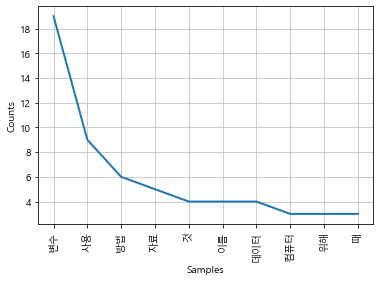

In [87]:
forcount.plot(10)
plt.show()

### 불용어처리

In [89]:
stopwords = pd.read_csv("stopwords.txt")

stopwords = stopwords['불용어'].tolist()

okt_morphs = okt.pos(texts)
Noun_words = okt.nouns(texts)

for word, pos in okt_morphs:
    if pos == 'Noun':
        Noun_words.append(word)
print(Noun_words)

['앞', '잠시', '언급', '것', '컴퓨터', '프로그래밍', '컴퓨터', '작업', '위해', '자료', '주어', '우리', '자료', '컴퓨터', '그', '자료', '메모리', '어딘가', '저장', '때', '사용', '그', '자료', '장소', '이름', '관리', '자료', '관리', '위해', '이름', '것', '변수', '개념', '설명', '위해', '프로그래밍', '사용', '데이터', '일정', '그릇', '설명', '즉', '변수', '그릇', '데이터', '때', '사용', '거', '데이터', '그냥', '변수', '것', '만약', '전', '데이터', '다라', '미리', '변수', '대신', '상수', '변수', '의미', '변수', '안', '사용', '요', '파이썬', '외', '모든', '프로그래밍언어', '변수', '사용', '프로그래밍언어', '변수', '사용', '방법', '다른', '경우', '즉', '각각', '프로그래밍언어', '방법', '사용', '경우', '파이썬', '변수', '방법', '정말', '변수', '담배값', '미분법', '정말', '다만', '변수', '생', '때', '몇', '가지', '규칙', '그것', '몇', '가지', '규칙', '무엇', '먼저', '직접', '변수', '변수', '이름', '반드시', '문자', '나', '언더스코어', '시작', '숫자', '특수문자', '시작', '안', '숫자', '특수문자', '변수', '이름', '사용', '것', '대문자', '소문자', '다른', '글자', '생각', '파이썬', '사용', '단어', '규칙', '만', '변수', '방법', '변수', '방법', '아주', '다음', '그림', '변수', '아파트', '변수', '생', '예제', '화면', '변수', '방법', '아주', '앞', '잠시', '언급', '것', '컴퓨터', '프로그래밍', '컴퓨터', '작업', '위해', '자료', '주어', '우리', '자

In [90]:
unique_Noun_words = set(Noun_words)
for word in unique_Noun_words:
    if word in stopwords:
        while word in Noun_words: Noun_words.remove(word)

In [91]:
from collections import Counter
c = Counter(Noun_words)
print(c.most_common(10))

[('변수', 38), ('사용', 18), ('방법', 12), ('자료', 10), ('이름', 8), ('데이터', 8), ('컴퓨터', 6), ('위해', 6), ('파이썬', 6), ('프로그래밍언어', 6)]


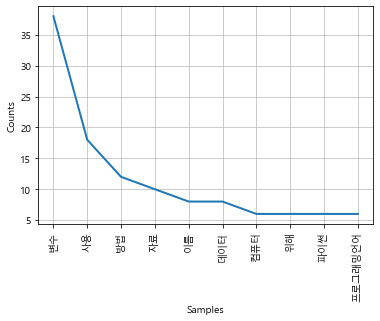

In [92]:
forcount = Text(Noun_words, name="textss")
forcount.plot(10)
plt.show()

### 워드클라우드

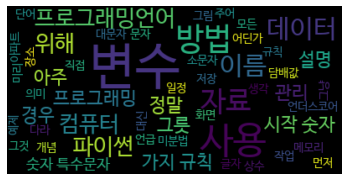

In [93]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os import path

FONT_PATH = 'c:/Windows/Fonts/nanum/NanumBarunGothic.ttf' # For Korean characters

noun_text = ''
for word in Noun_words:
    noun_text = noun_text +' '+word

wordcloud = WordCloud(max_font_size=60, relative_scaling=.5, font_path=FONT_PATH).generate(noun_text) # generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()